In [2]:
from utils.command_handler import ScriptParser, Command
import numpy as np
import cv2
import imutils
from PIL import Image, ImageTk, ImageFont, ImageDraw, ImageChops
from matplotlib import pyplot as plt
import external_functions.base_functions as bf
import os
import time
import pyvisa
import logging

logger = logging.getLogger(__name__)

In [2]:
path = f"test/utils/mminus-v{str((2))}.png"
path = os.path.abspath(os.path.join(os.getcwd(), path))
im1 = Image.open(path)
im2 = Image.open(path.replace("mminus", "mplus"))

In [3]:
mapka = bf.standard_map(im1, im2)

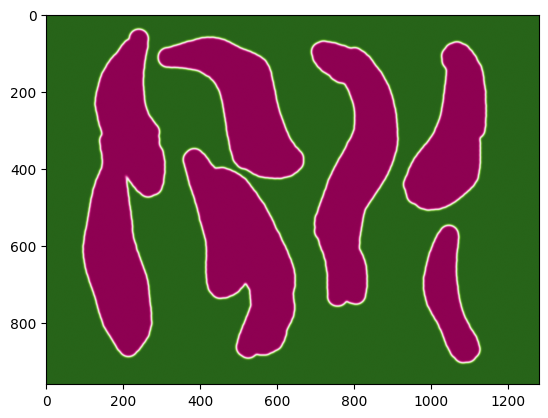

In [9]:
plt.imshow(mapka, cmap="PiYG")

In [ ]:
def check_mapka(mapka, size=400, thresh=0.005):
    width = size
    height = size

    mask = np.zeros(mapka.shape)
    center_point = (int(mask.shape[1] / 2), int(mask.shape[0] / 2))
    start_point, end_point = center_size2start_end(center_point, size)
    mask = cv2.rectangle(
        mask,
        start_point,
        end_point,
        1,
        -1,
    )

    masked = mapka * mask
    pos = masked[masked > thresh].shape[0]
    neg = masked[masked < -thresh].shape[0]
    dead = (width * height) - masked[(abs(masked) > thresh)].shape[0]
    return pos / (pos + neg + 1), dead / (width * height)


def center_size2start_end(center: tuple[int, int], size: int) -> tuple[tuple[int, int], tuple[int, int]]:
    """
    Converts rectangle coords from center and size to start ane end point
    """
    half_size = int(size/2)
    start_point = (center[1] - half_size, center[0] - half_size)
    end_point = (center[1] + half_size, center[0] + half_size)
    return start_point, end_point

In [52]:
size = 400
def check_side_opening(mapka, open_coords, size=400, check_size = 200, thresh=0.005):
    """
    mapka: -1 to 1 float array
    open_coords: coords in range 0-1 of the open square, where 1 is on the edge and 0 in the center
    size: size in pixels of the whole pixel that is located at the center
    check_size: size of the side opening [px]
    """
    open_x, open_y = open_coords
    mask = np.zeros(mapka.shape)
    center_point = (int(mask.shape[0] / 2), int(mask.shape[1] / 2))

    check_point = (center_point[0] + int(open_y*size/2), center_point[1] + int(open_x*size/2))
    start_point, end_point = center_size2start_end(check_point, check_size)
    mask = cv2.rectangle(
        mask,
        start_point,
        end_point,
        1,
        -1,
    )

    masked = mapka * mask
    pos = masked[masked > thresh].shape[0]
    neg = masked[masked < -thresh].shape[0]
    dead = (check_size * check_size) - masked[(abs(masked) > thresh)].shape[0]
    return pos / (pos + neg + 1), dead / (check_size * check_size)

In [ ]:
check_side_opening(mapka, (-1, 0))


def find_side_opening(mapka, size=400, check_size=200):
    points = [(float(x), float(y)) for x in (-1, 1) for y in np.linspace(-1, 1, 11)]
    points.extend([(point[1], point[0]) for point in points])
    sorted_points = sorted(points, key=lambda point: check_side_opening(mapka, point, size=size, check_size=check_size))
    best_point = sorted_points[-1]
    best_res = check_side_opening(mapka, best_point)
    if best_res[0] > 0.9:
        return best_point
    else:
        return (100, 100)  # return point outside the area


In [59]:
find_side_opening(mapka, size=400)

(0.40000000000000013, -1.0) (0.782126500804555, -0.00985)


In [60]:
mapka.shape

(960, 1280)

In [17]:
os.listdir("saved_images/")

['image_00001.png']

In [14]:
"ssssss".split(".")

['ssssss']

In [13]:
result

defaultdict(list, {'foo': [1, 2], 'bąr': [10], 'baz': [1234]})

In [1]:
float("-0.213")

-0.213

In [2]:
def add_image(base_image, new_image, coords: tuple[int, int]):
    """
    Paste `new_image` onto `base_image` at top-left pixel `coords=(x, y)`.
    If the paste exceeds base bounds, the output canvas is expanded and
    the empty area is filled with black (0,0,0) for color or 0 for grayscale.

    - Accepts grayscale (HxW), 3-channel (HxWx3), and 4-channel (HxWx4) arrays.
    - If `new_image` has an alpha channel, it is used to alpha-composite onto the canvas.
    - Dtypes are preserved via numpy.result_type of both inputs.
    - `coords` may be negative to paste above/left of the base image's origin.

    Returns
    -------
    np.ndarray
        The combined image with shape large enough to contain both.
    """
    x, y = int(coords[0]), int(coords[1])

    base = np.asarray(base_image)
    new  = np.asarray(new_image)

    # Common dtype
    out_dtype = np.result_type(base.dtype, new.dtype)

    def split_alpha(img):
        if img.ndim == 3 and img.shape[2] == 4:
            return img[..., :3], img[..., 3]
        return img, None

    # Separate color and alpha if present
    b_rgb, _   = split_alpha(base)
    n_rgb, n_a = split_alpha(new)

    # Decide output color plane count (1 or 3). If any is color, use 3.
    want_rgb = 3 if ((b_rgb.ndim == 3 and b_rgb.shape[2] == 3) or
                     (n_rgb.ndim == 3 and n_rgb.shape[2] == 3)) else 1

    def to_channels(img, ch):
        if img.ndim == 2 and ch == 3:
            return np.repeat(img[..., None], 3, axis=2)
        elif img.ndim == 3 and img.shape[2] == 3 and ch == 1:
            # Convert color → gray (simple luminance approximation)
            # Works for either RGB or BGR ordering; weights are generic.
            return (0.114*img[..., 0] + 0.587*img[..., 1] + 0.299*img[..., 2]).astype(img.dtype)
        else:
            return img

    b_rgb = to_channels(b_rgb, want_rgb)
    n_rgb = to_channels(n_rgb, want_rgb)

    # Cast to common dtype
    b_rgb = b_rgb.astype(out_dtype, copy=False)
    n_rgb = n_rgb.astype(out_dtype, copy=False)

    Hb, Wb = b_rgb.shape[:2]
    Hn, Wn = n_rgb.shape[:2]

    # Compute bounding box of union (base at (0,0), new at (x,y))
    min_x = min(0, x)
    min_y = min(0, y)
    max_x = max(Wb, x + Wn)
    max_y = max(Hb, y + Hn)

    out_W = max_x - min_x
    out_H = max_y - min_y

    # Create black canvas
    if want_rgb == 1:
        canvas = np.zeros((out_H, out_W), dtype=out_dtype)
    else:
        canvas = np.zeros((out_H, out_W, 3), dtype=out_dtype)

    # Offsets for placing images into the canvas
    bx, by = -min_x, -min_y
    nx, ny = x - min_x, y - min_y

    # Paste base image
    if want_rgb == 3:
        canvas[by:by+Hb, bx:bx+Wb, :] = b_rgb
    else:
        canvas[by:by+Hb, bx:bx+Wb] = b_rgb

    # Paste new image (with optional alpha compositing)
    if n_a is not None:
        # Ensure alpha is float in [0,1]
        alpha = n_a.astype(np.float32)
        if alpha.max() > 1.0:
            alpha = alpha / 255.0
        if want_rgb == 3:
            alpha = alpha[..., None]

        y1, y2 = ny, ny + Hn
        x1, x2 = nx, nx + Wn

        roi = canvas[y1:y2, x1:x2]  # view
        roi_f = roi.astype(np.float32)
        new_f = n_rgb.astype(np.float32)

        blended = new_f * alpha + roi_f * (1.0 - alpha)
        canvas[y1:y2, x1:x2] = blended.astype(out_dtype)
    else:
        if want_rgb == 3:
            canvas[ny:ny+Hn, nx:nx+Wn, :] = n_rgb
        else:
            canvas[ny:ny+Hn, nx:nx+Wn] = n_rgb

    return canvas

In [14]:
base = np.ones((150, 150, 3), np.uint8)
img = np.ones((50, 50, 3), np.uint8)*126

combine = add_image(base, img, (130, 30))

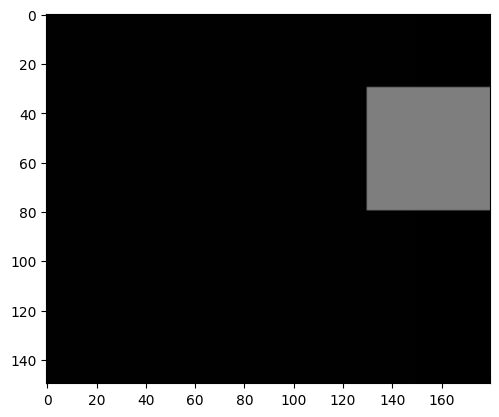

In [15]:
plt.imshow(combine)

In [3]:
53//10 + 1 if (53%10 > 0) else 0

6

In [3]:
img = np.zeros((100, 100, 3), np.uint8)

In [5]:
img2 = img[30:,30:,:]

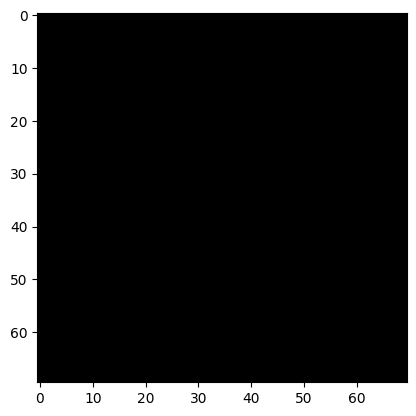

In [6]:
plt.imshow(img2)